# Seasonal cycle

Assessment of seasonal cycle.

The assessment involves calculating the monthly climatology at each grid point and then summing the absolute value of the difference between the bias corrected model data and observations acorss all twelve months. That sum represents the seasonal cycle bias.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import calendar

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import utils

In [2]:
def monthly_climatology(da, var):
    """Calculate the monthly rainfall climatology"""
    
    if var == 'pr':
        da_monthly = da.resample(time='1M').sum('time')
        monthly_means = da_monthly.groupby('time.month').mean('time')
    else:
        monthly_means = da.groupby('time.month').mean('time')
    monthly_means = monthly_means.compute()
    
    return monthly_means

In [3]:
def get_data(var, gcm, rcm, task):
    """Get data needed for the evaluation"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']

    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    da_dict = {}
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['obs'] = monthly_climatology(da_obs, var)
   
    da_gcm = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['gcm'] = monthly_climatology(da_gcm, var)
    
    da_rcm_raw = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_raw'] = monthly_climatology(da_rcm_raw, var)
    
    da_rcm_ecdfm = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU',
    )
    da_dict['rcm_ecdfm'] = monthly_climatology(da_rcm_ecdfm, var)
    
    da_rcm_qme = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_qme'] = monthly_climatology(da_rcm_qme, var)
    
    if task == 'xvalidation':
        da_rcm_qdm = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU',
        )
        da_dict['rcm_qdm'] = monthly_climatology(da_rcm_qdm, var)
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [4]:
def plot_cycle_bias(ax, obs_cycle, model_cycle, cmap, levels, model_name, fraction=False, ob_fractions=None):
    """Plot the cycle bias for a particular model"""
    
    monthly_bias = model_cycle - obs_cycle
    total_bias = np.abs(monthly_bias).sum(dim='month')
    if fraction:
        annual_total = obs_cycle.sum(dim='month')
        total_bias = total_bias / annual_total    
        units = 'bias (as a fraction of total annual rainfall)'
    else:
        units = 'mm'
    total_bias = utils.clip_data(total_bias, utils.get_aus_shape())
    if ob_fractions is not None:
        total_bias = utils.mask_by_pr_ob_fraction(total_bias, ob_fractions, threshold=0.9) 
    ave_bias = np.nanmean(total_bias.values)
    
    total_bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='max',
        cbar_kwargs={'label': units},
    )
    ax.text(0.02, 0.02, f'Spatial average: {ave_bias:.2f}', transform=ax.transAxes)
    ax.set_title(model_name)
    ax.coastlines()

In [5]:
def plot_cycle_bias_comparison(da_dict, var, gcm, rcm, task, cmap, levels, fraction=False):
    """Plot the complete comparison"""

    ncols = 5 if task == 'xvalidation' else 4
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    
    fig = plt.figure(figsize=[7 * ncols, 5])
    ax1 = fig.add_subplot(1, ncols, 1, projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax1, da_dict['obs'], da_dict['gcm'], cmap, levels, gcm, fraction=fraction, ob_fractions=ob_fractions,
    )
    ax2 = fig.add_subplot(1, ncols, 2, projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax2, da_dict['obs'], da_dict['rcm_raw'], cmap, levels, f'{rcm} (raw)', fraction=fraction, ob_fractions=ob_fractions,
    )
    ax3 = fig.add_subplot(1, ncols, 3, projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax3, da_dict['obs'], da_dict['rcm_ecdfm'], cmap, levels, f'{rcm} (ecdfm)', fraction=fraction, ob_fractions=ob_fractions,
    )
    ax4 = fig.add_subplot(1, ncols, 4, projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax4, da_dict['obs'], da_dict['rcm_qme'], cmap, levels, f'{rcm} (qme)', fraction=fraction, ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        ax5 = fig.add_subplot(1, ncols, 5, projection=ccrs.PlateCarree())
        plot_cycle_bias(
            ax5, da_dict['obs'], da_dict['rcm_qdm'], cmap, levels, f'{rcm} (qdm)', fraction=fraction, ob_fractions=ob_fractions,
        )
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Seasonal cycle bias (model minus obs) in {start_year}-2019 monthly mean')
    plt.show()

In [6]:
cities = {
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Darwin': {'lat': -12.5, 'lon': 131},
    'Cairns': {'lat': -16.9, 'lon': 145},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},    
}

In [7]:
def plot_city_cycle(ax, da, city, name):
    """Plot seasonal cycle"""
    
    xticks = np.arange(1, 13)
    da_point = da.sel(cities[city], method='nearest')
    ax.plot(xticks, da_point.values, label=name, linewidth=3.0, marker='o')

In [8]:
def plot_city_cycles(da_dict, gcm, rcm, task):
    """Plot the seasonal cycle for a bunch of cities"""

    xticks = np.arange(1, 13)
    xtick_labels = [calendar.month_abbr[i] for i in xticks]
    
    fig = plt.figure(figsize=[28, 15])
    for plotnum, city in enumerate(cities):
        ax = fig.add_subplot(3, 4, plotnum+1)
        plot_city_cycle(ax, da_dict['obs'], city, 'AGCD')
        plot_city_cycle(ax, da_dict['gcm'], city, gcm)
        plot_city_cycle(ax, da_dict['rcm_raw'], city, rcm)
        plot_city_cycle(ax, da_dict['rcm_ecdfm'], city, f'{rcm} (ECDFm)')
        plot_city_cycle(ax, da_dict['rcm_qme'], city, f'{rcm} (QME)')
        if task == 'xvalidation':
            plot_city_cycle(ax, da_dict['rcm_qdm'], city, f'{rcm} (QDM)')
        ax.set_title(city)
        ax.set_ylabel('monthly mean rainfall (mm)')
        ax.set_xticks(xticks, xtick_labels)
        if plotnum == 0:
            ax.legend()
        ax.grid()
        
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Seasonal cycle in {start_year}-2019 monthly mean')
    plt.show()

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [9]:
variable = 'tasmin'

if variable == 'pr':
    bias_levels = np.arange(0, 450, 50)
    frac_levels = np.arange(0, 1.5, 0.15)
else:
    bias_levels = np.arange(0, 20, 2)
    cmap = 'magma_r'

#### ERA5

In [10]:
gcm = 'ECMWF-ERA5'
rcm = 'BOM-BARPA-R'
task = 'historical'
da_dict = get_data(variable, gcm, rcm, task)

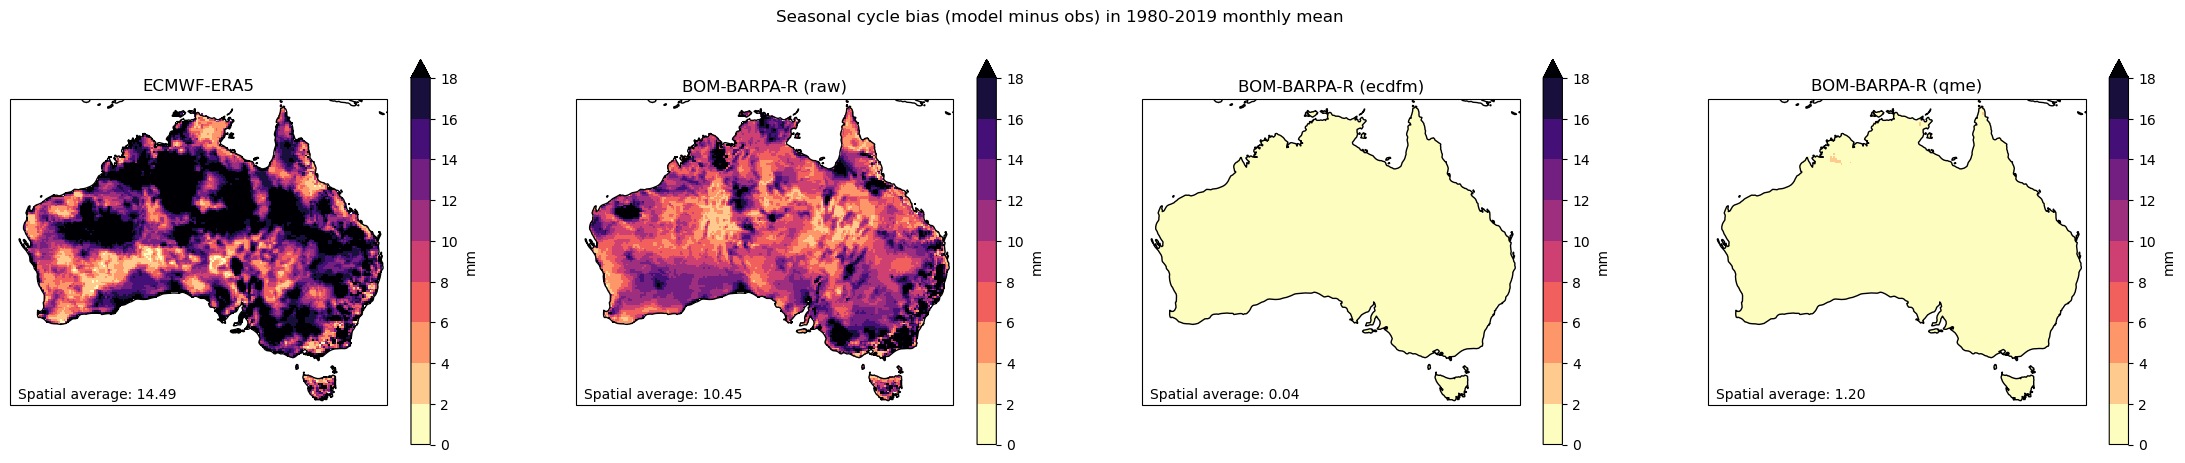

In [11]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [12]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, gcm, rcm, task, cmap, frac_levels, fraction=True)

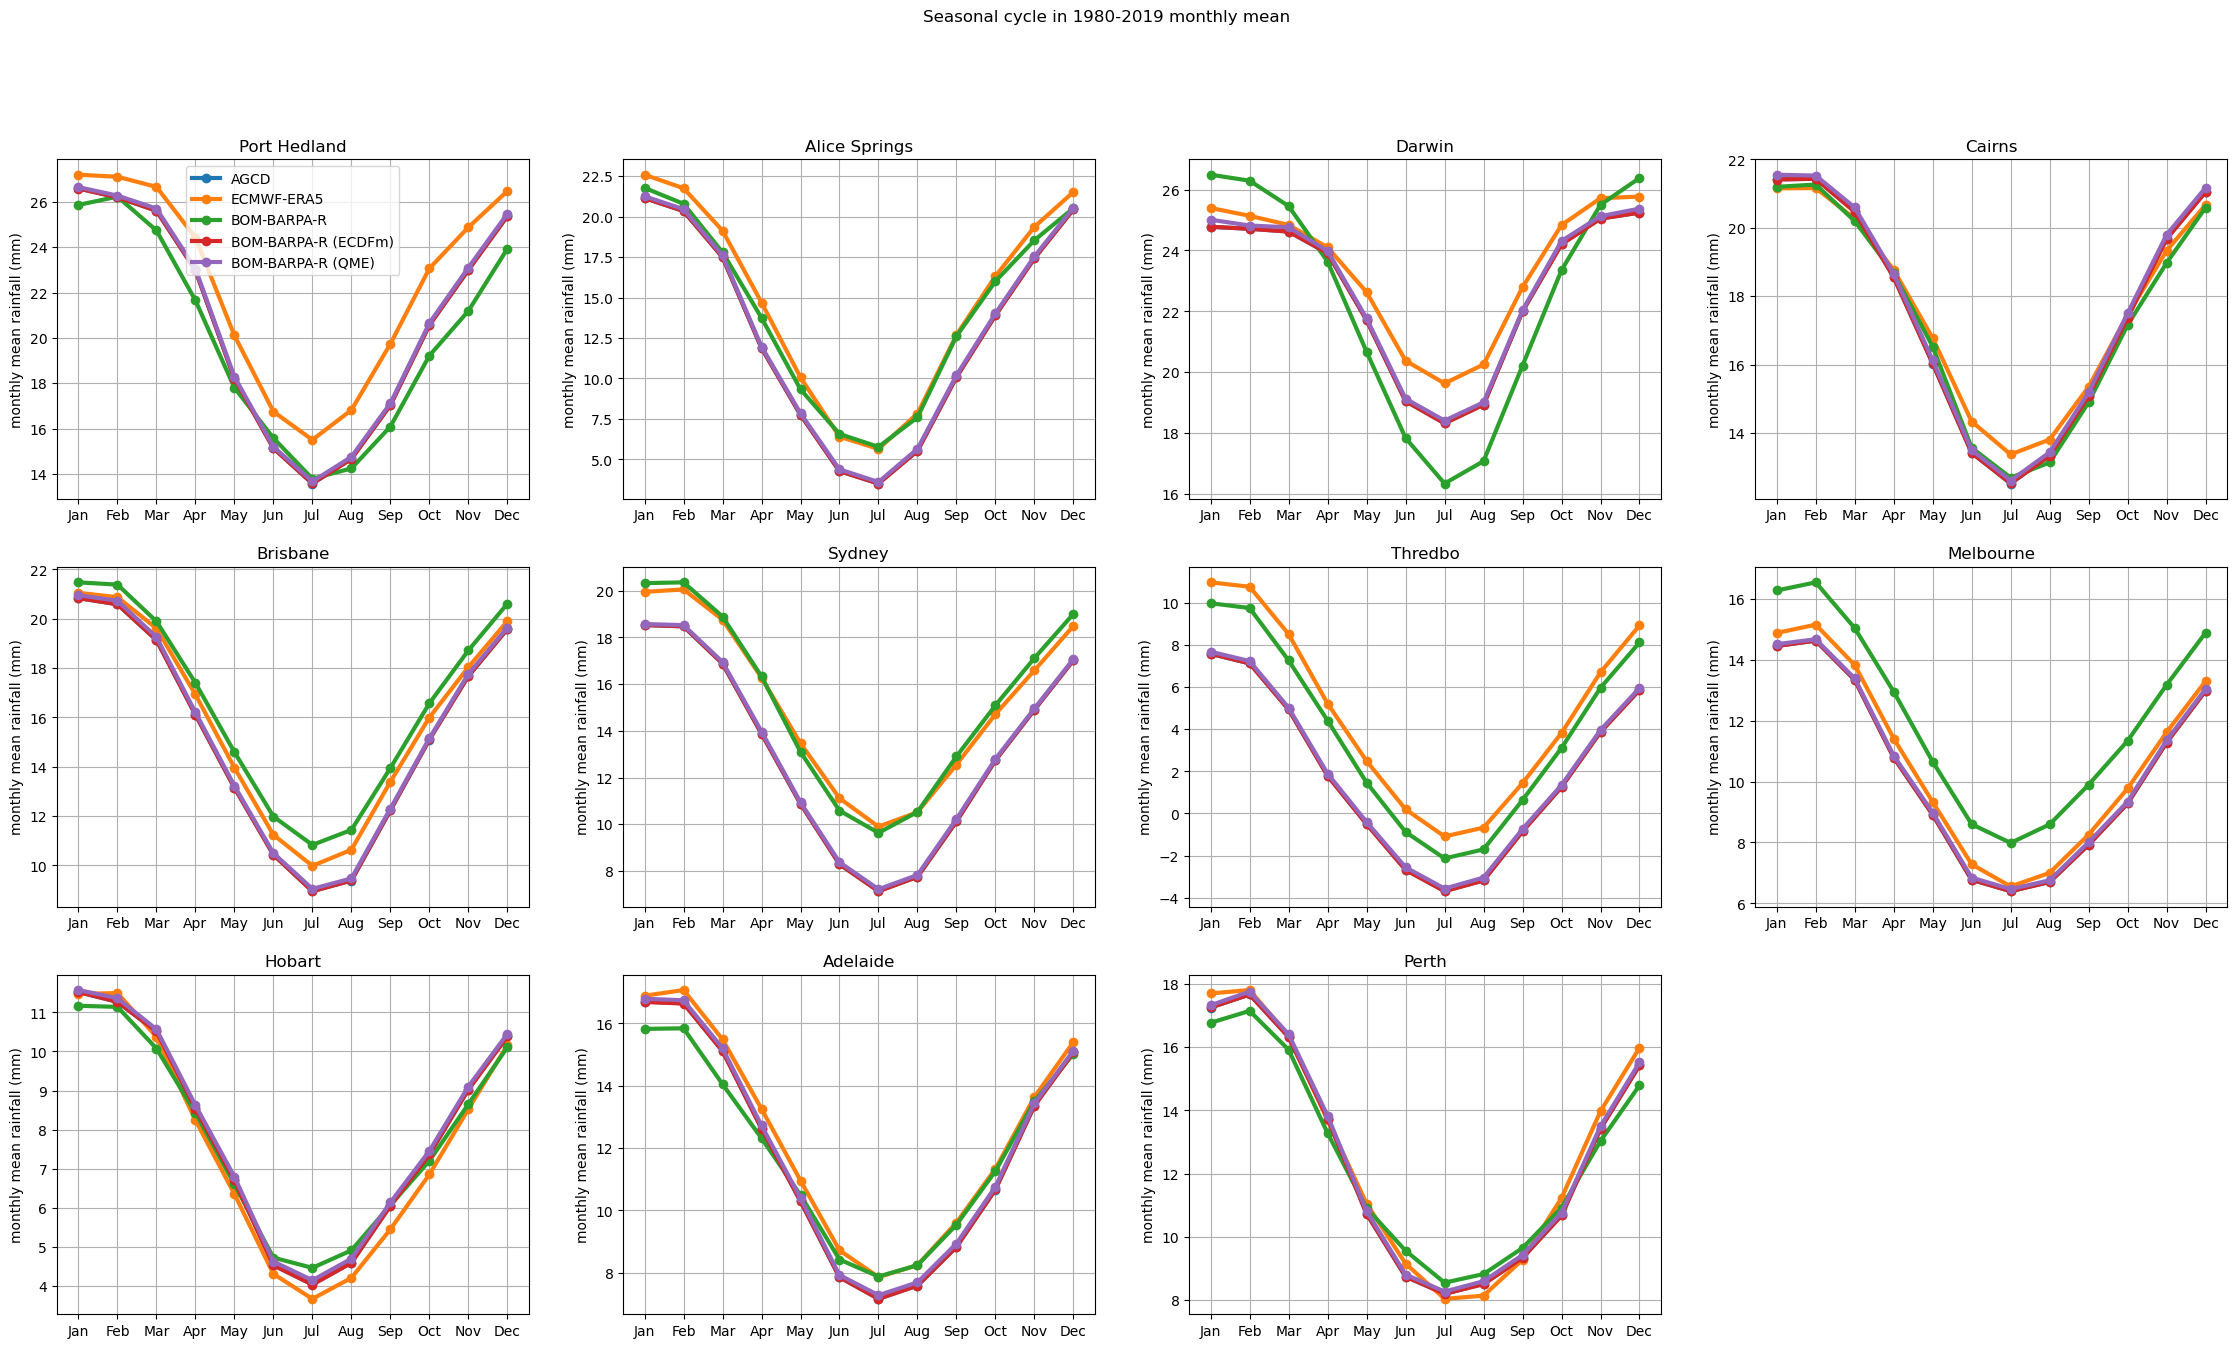

In [13]:
plot_city_cycles(da_dict, gcm, rcm, task)

In [14]:
gcm = 'ECMWF-ERA5'
rcm = 'CSIRO-CCAM-2203'
task = 'historical'
da_dict = get_data(variable, gcm, rcm, task)

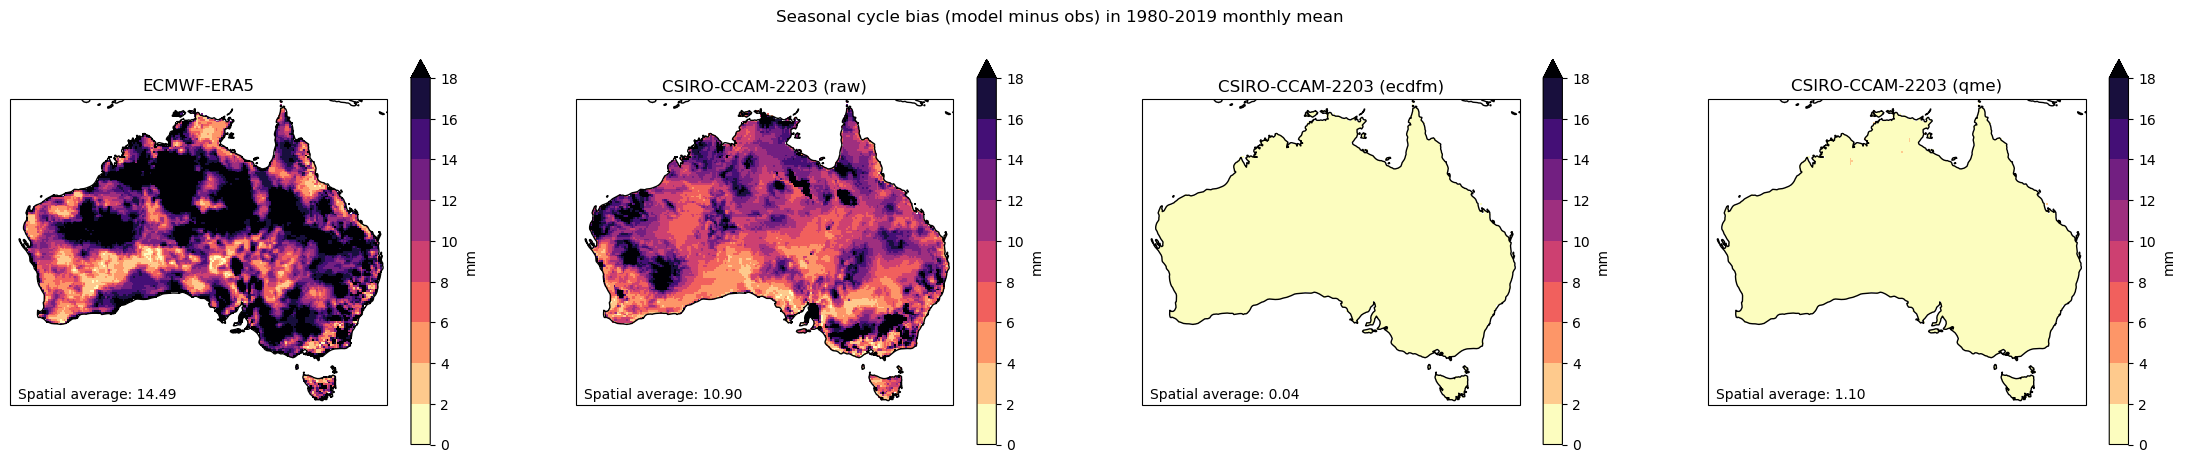

In [15]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [16]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, frac_levels, fraction=True)

In [17]:
gcm = 'ECMWF-ERA5'
rcm = 'UQ-DES-CCAM-2105'
task = 'historical'
da_dict = get_data(variable, gcm, rcm, task)

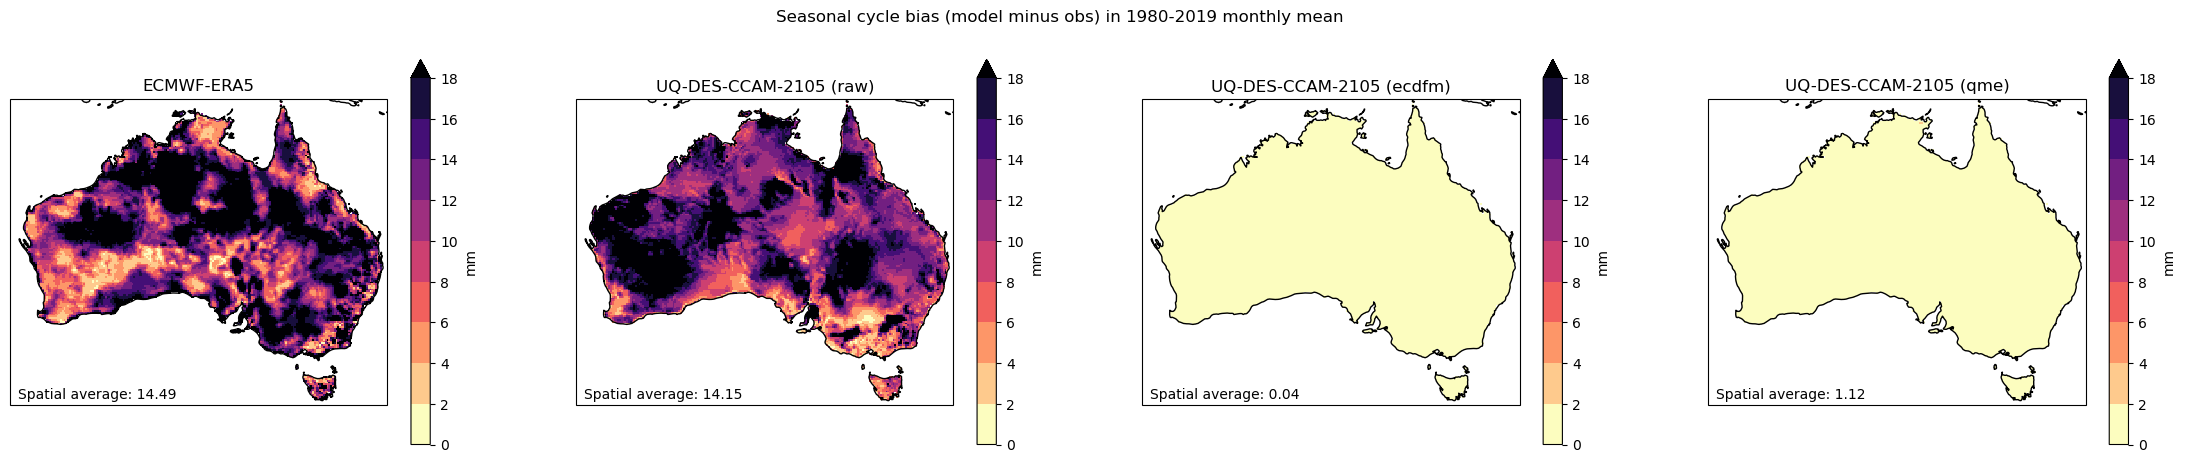

In [18]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [19]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, frac_levels, fraction=True)

## task-xvalidation

### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [20]:
gcm = 'ECMWF-ERA5'
rcm = 'BOM-BARPA-R'
task = 'xvalidation'
da_dict = get_data(variable, gcm, rcm, task)

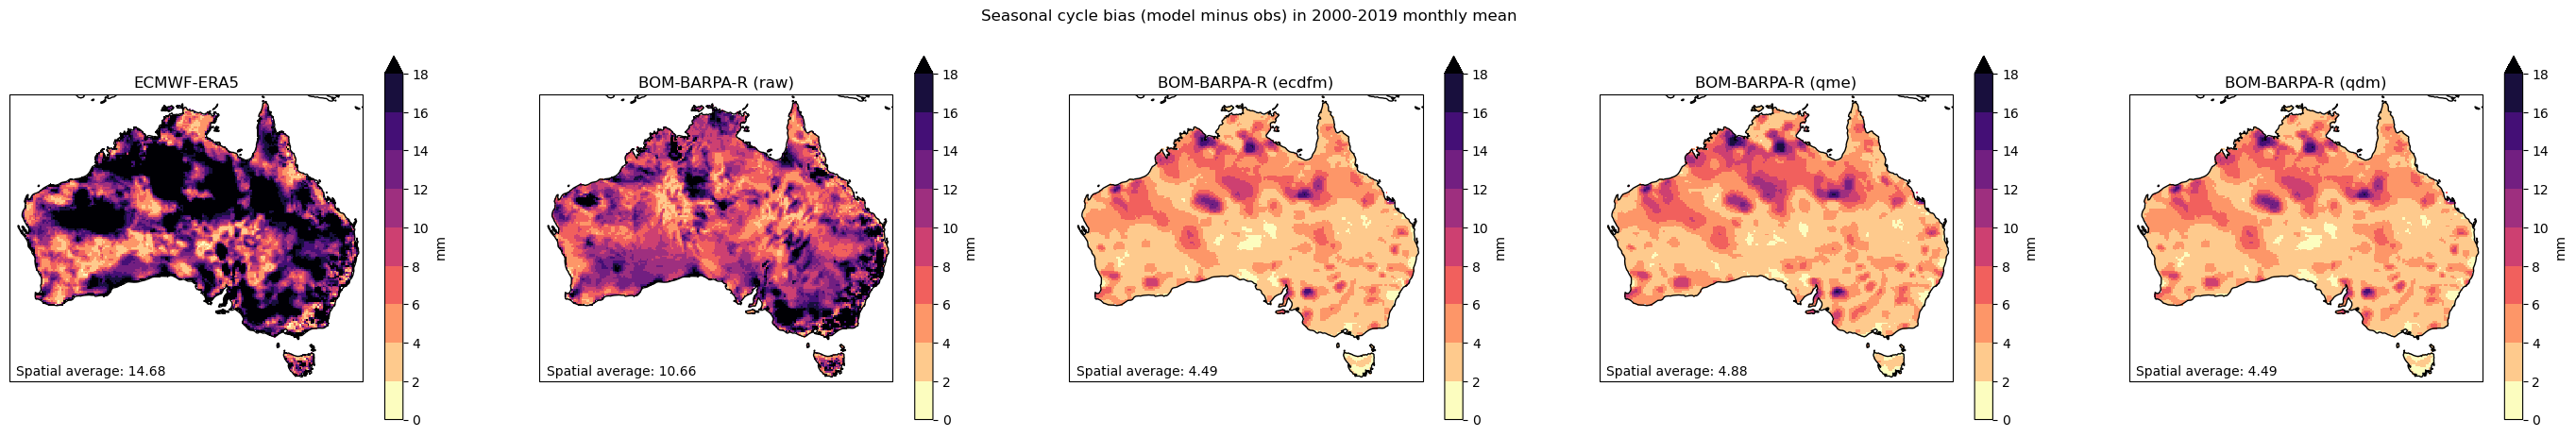

In [21]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [22]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, frac_levels, fraction=True)

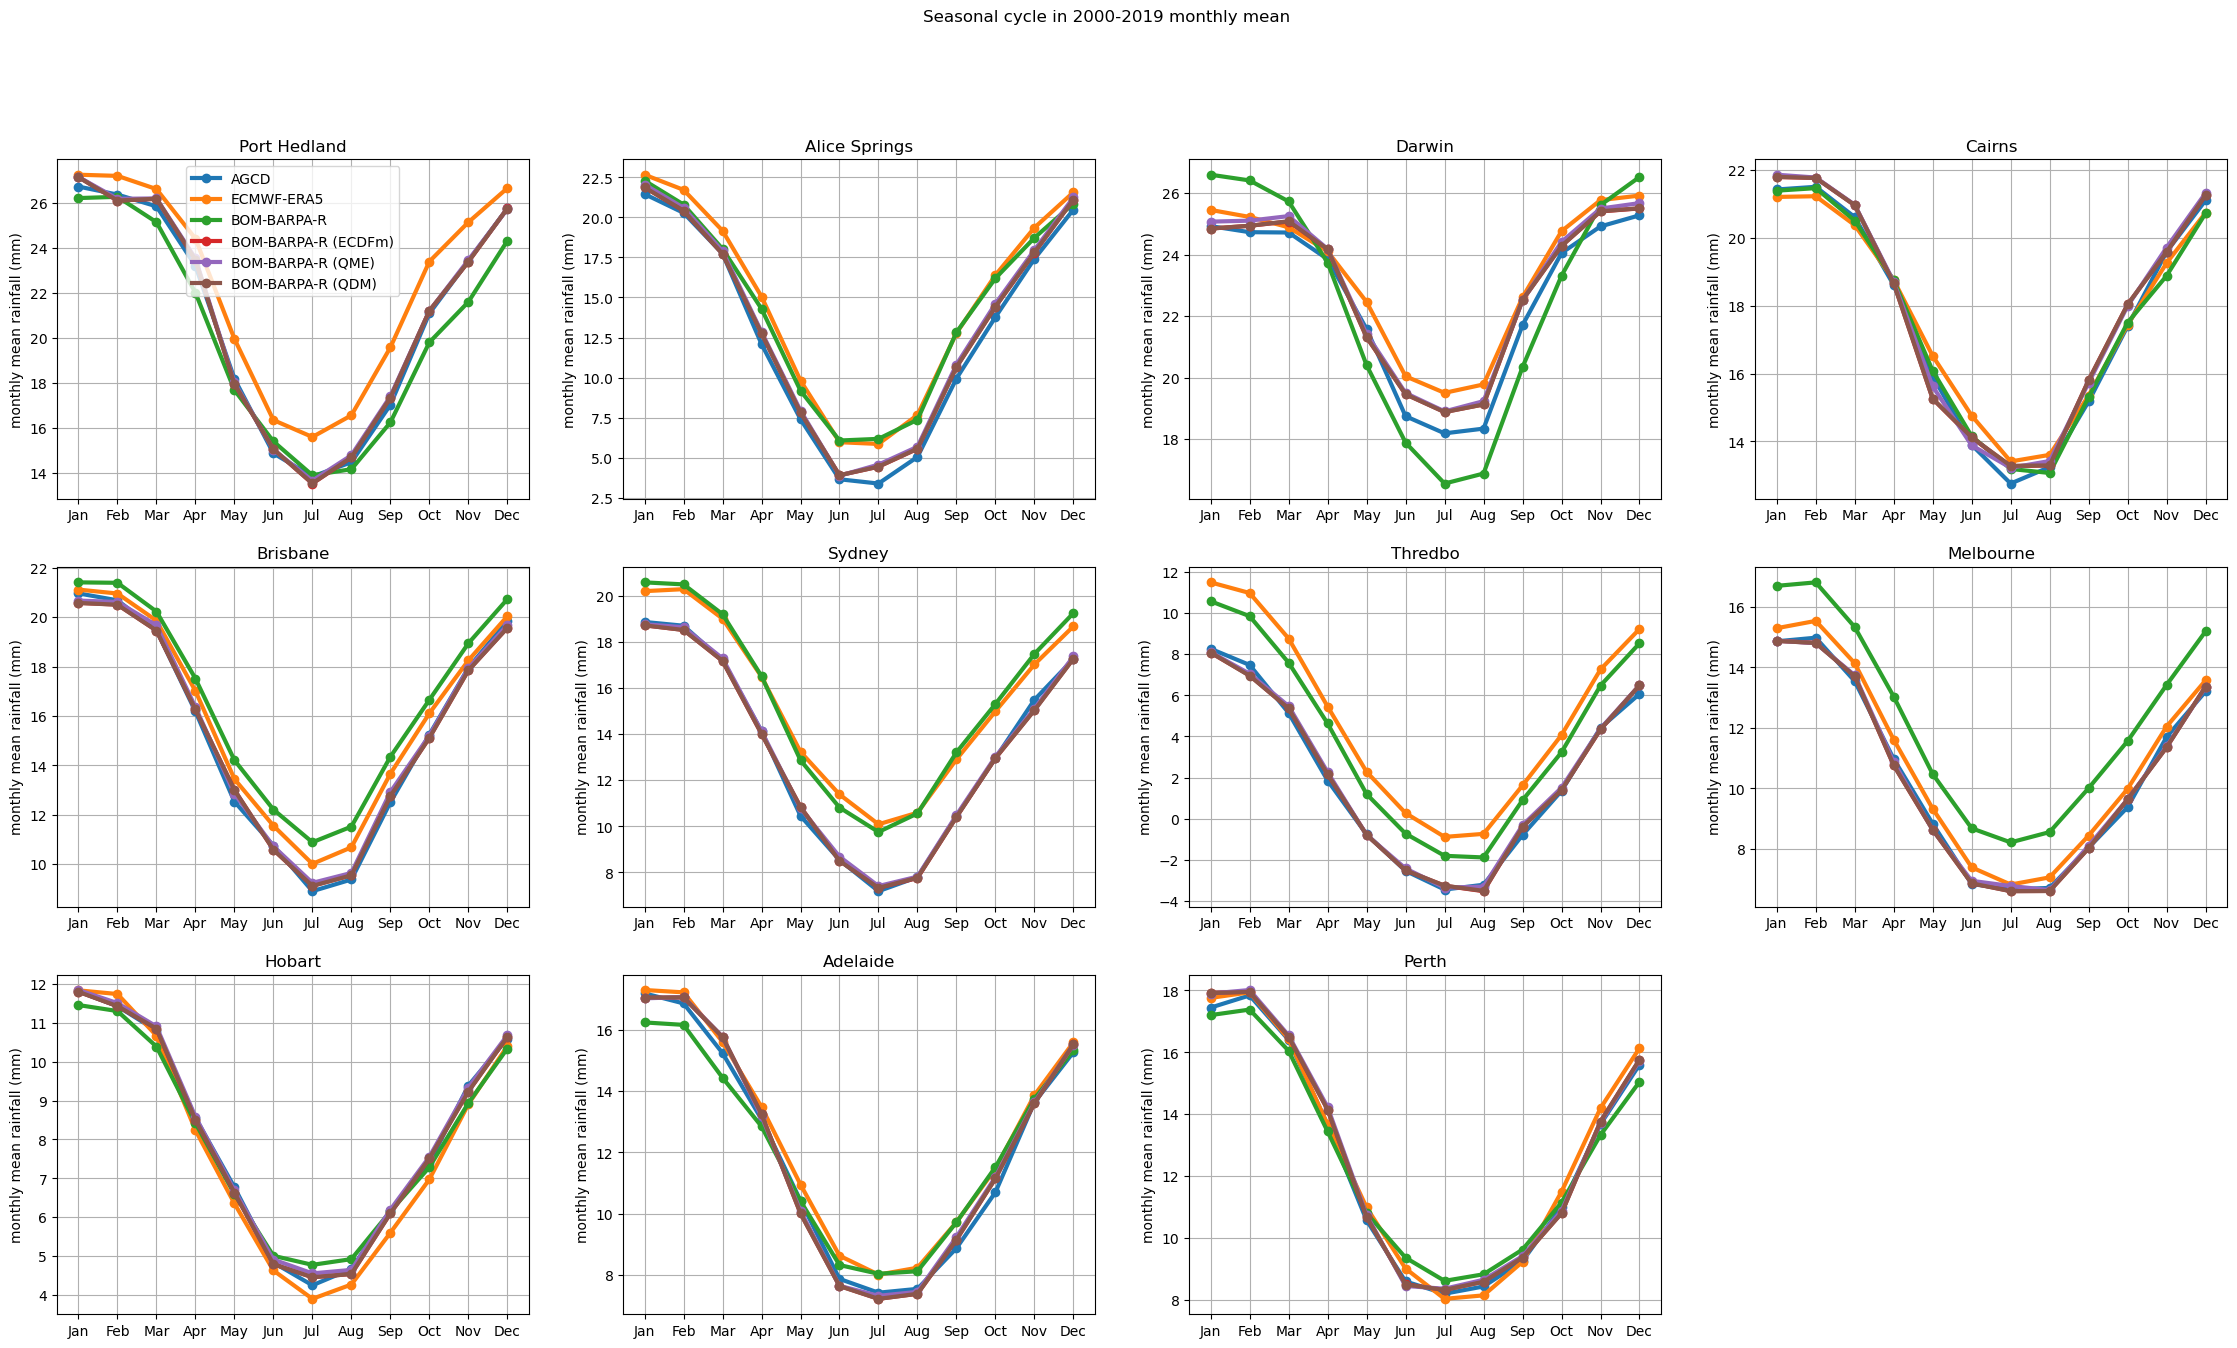

In [23]:
plot_city_cycles(da_dict, gcm, rcm, task)

In [24]:
gcm = 'ECMWF-ERA5'
rcm = 'CSIRO-CCAM-2203'
task = 'xvalidation'
da_dict = get_data(variable, gcm, rcm, task)

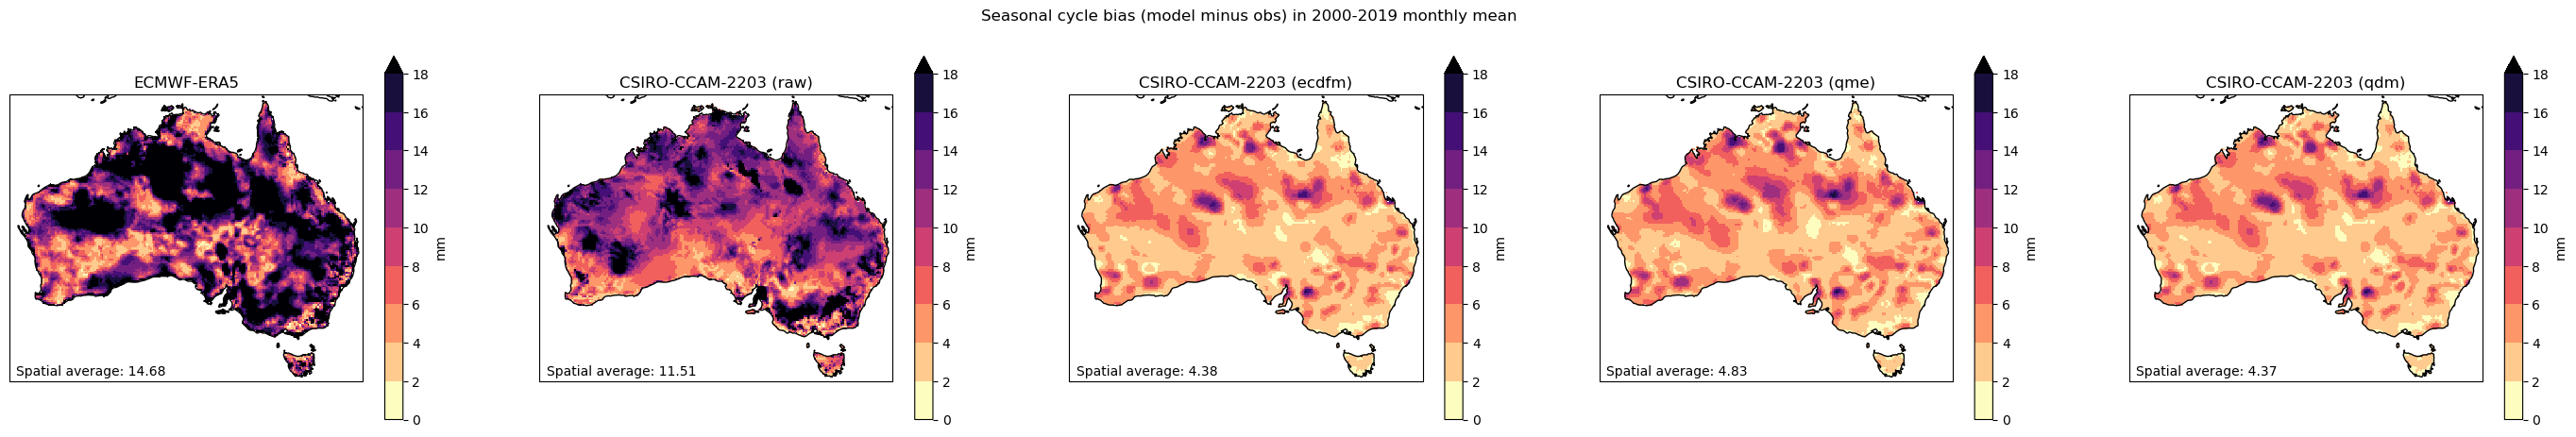

In [25]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [26]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, frac_levels, fraction=True)

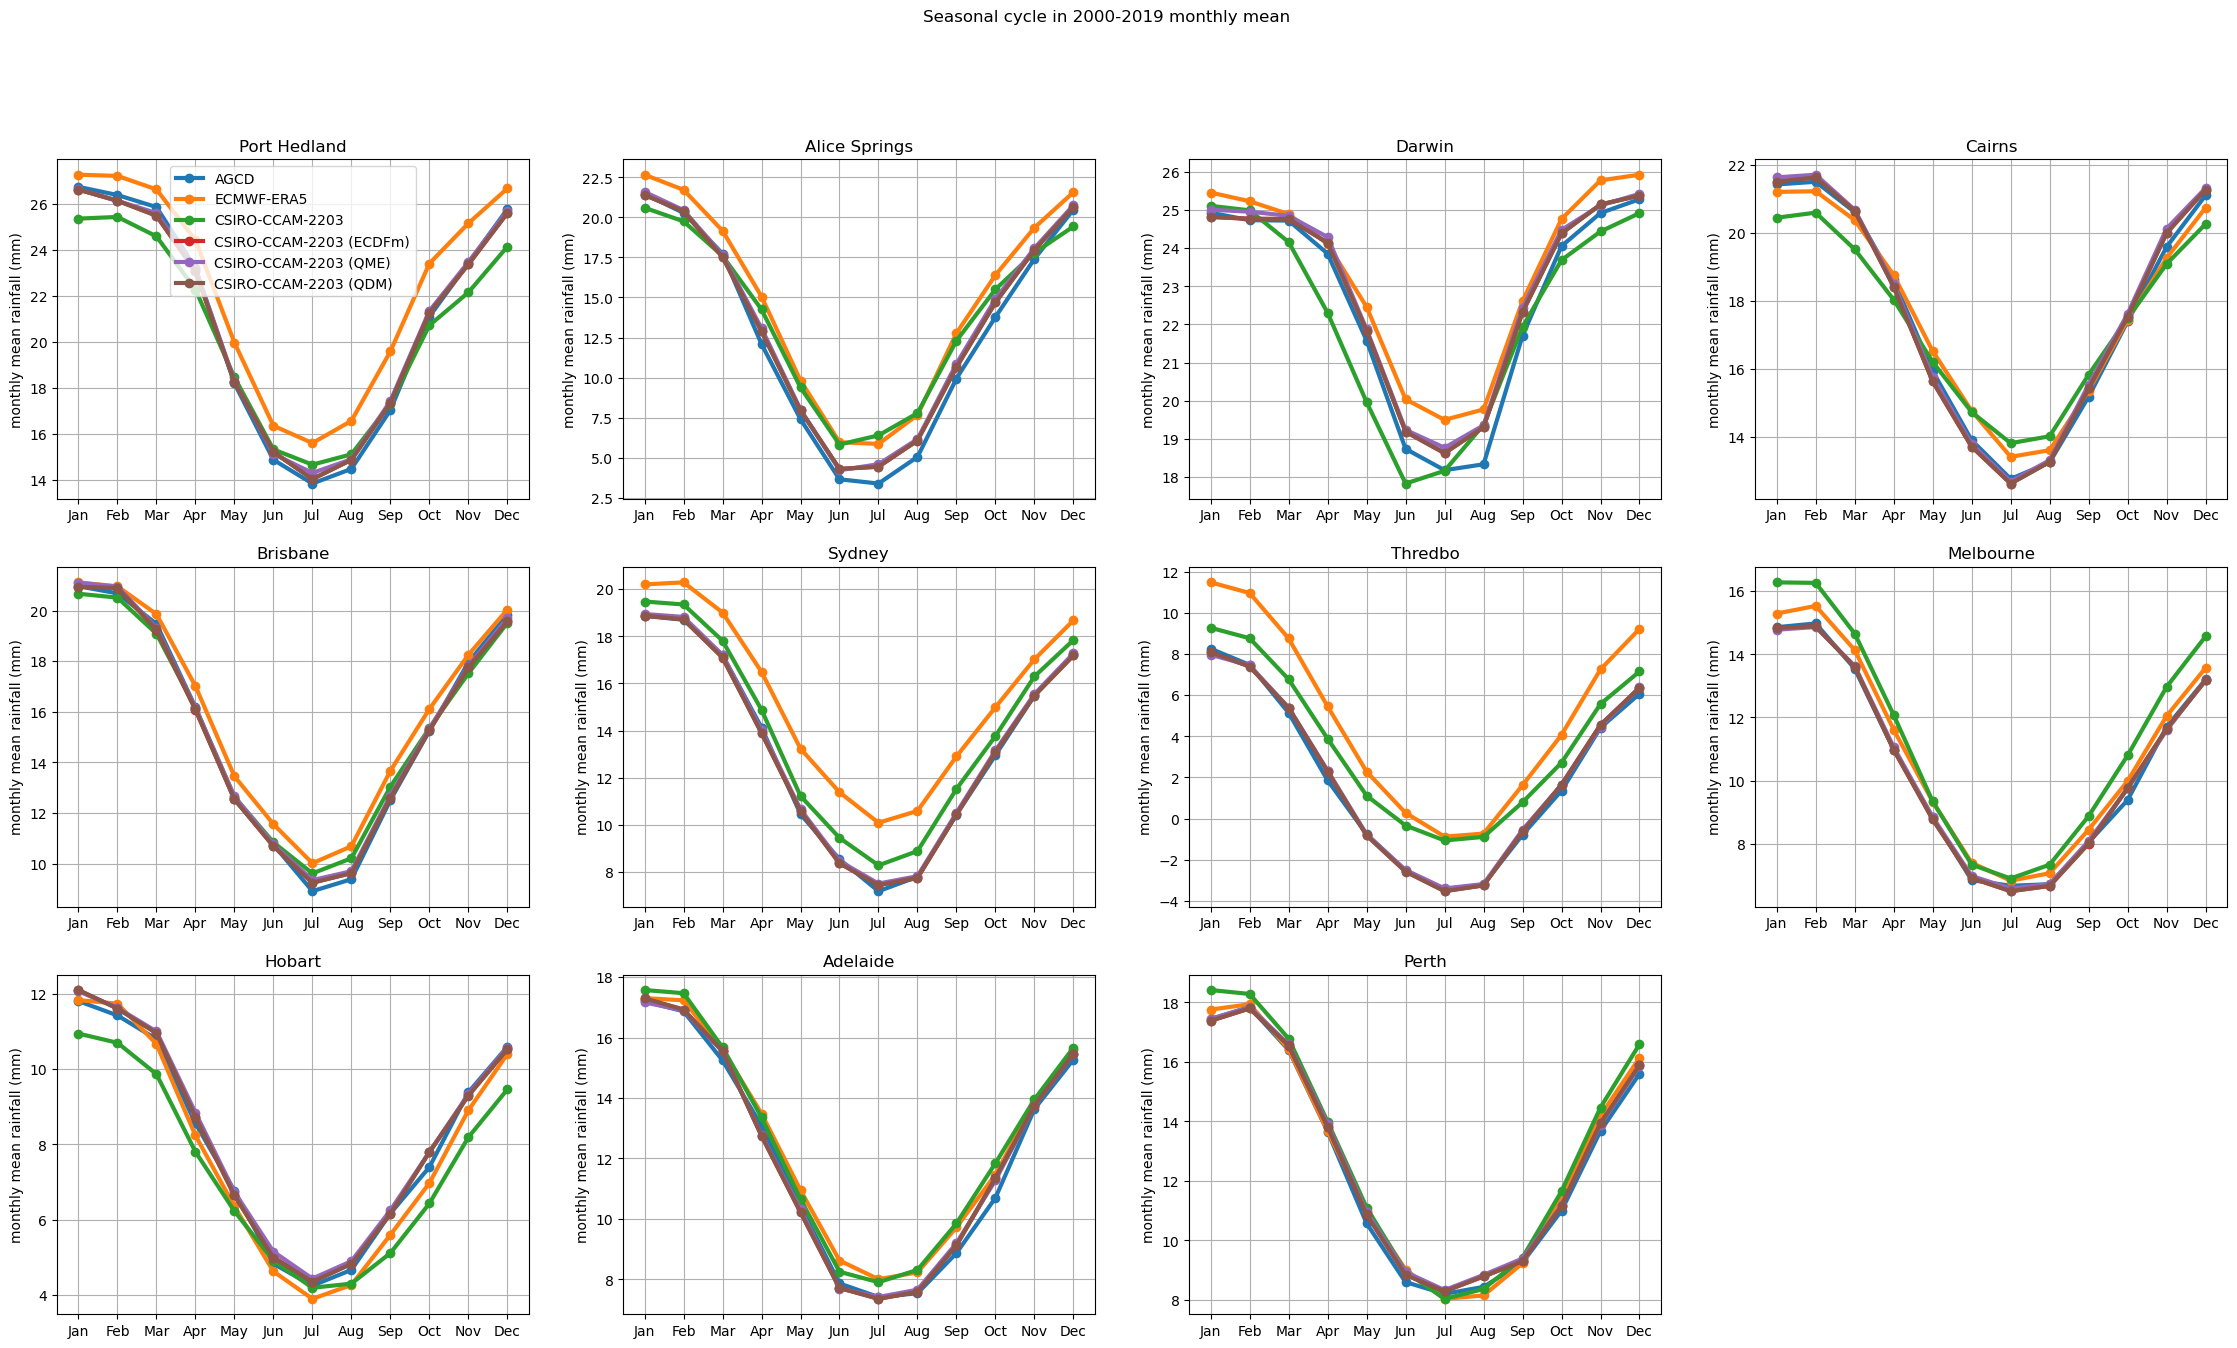

In [27]:
plot_city_cycles(da_dict, gcm, rcm, task)

In [28]:
gcm = 'ECMWF-ERA5'
rcm = 'UQ-DES-CCAM-2105'
task = 'xvalidation'
da_dict = get_data(variable, gcm, rcm, task)

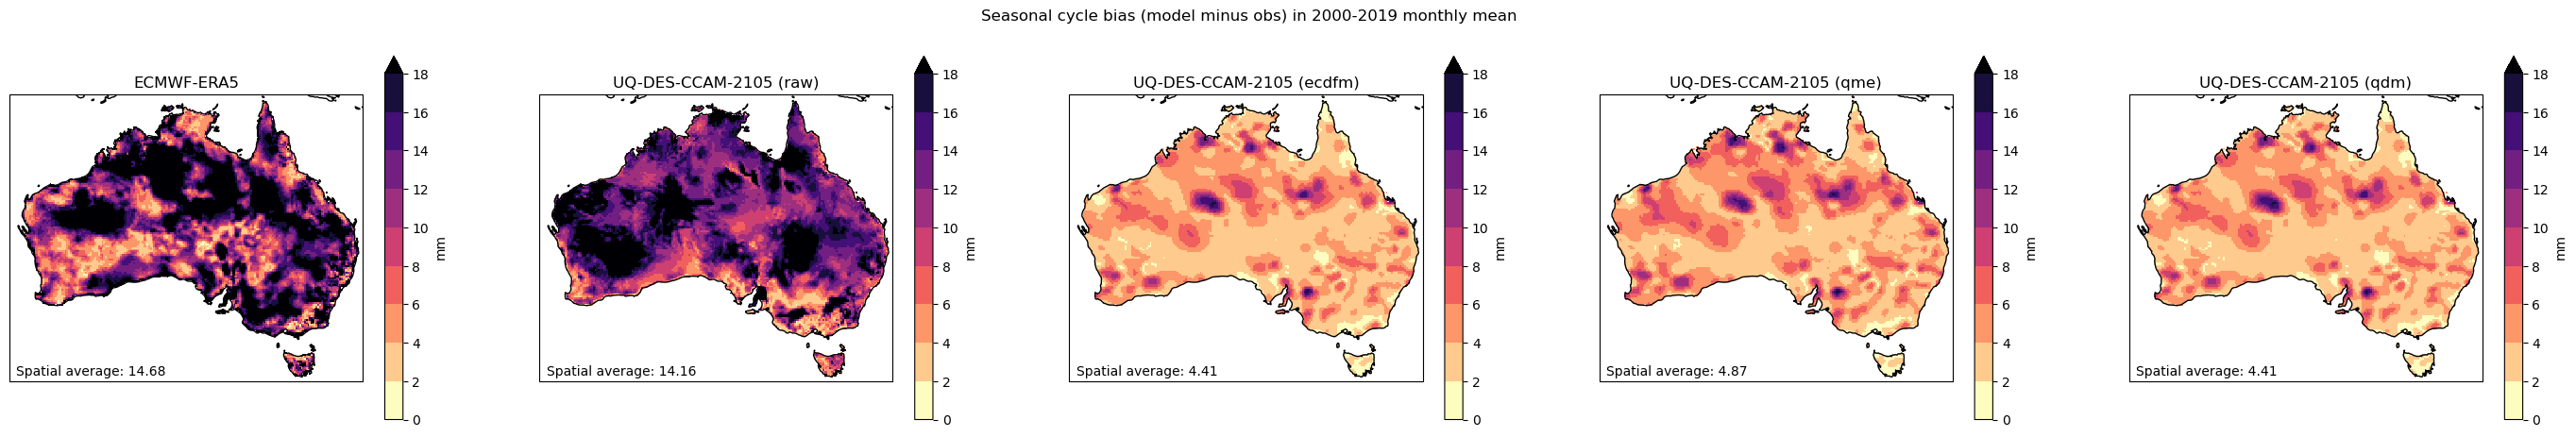

In [29]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [30]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, frac_levels, fraction=True)

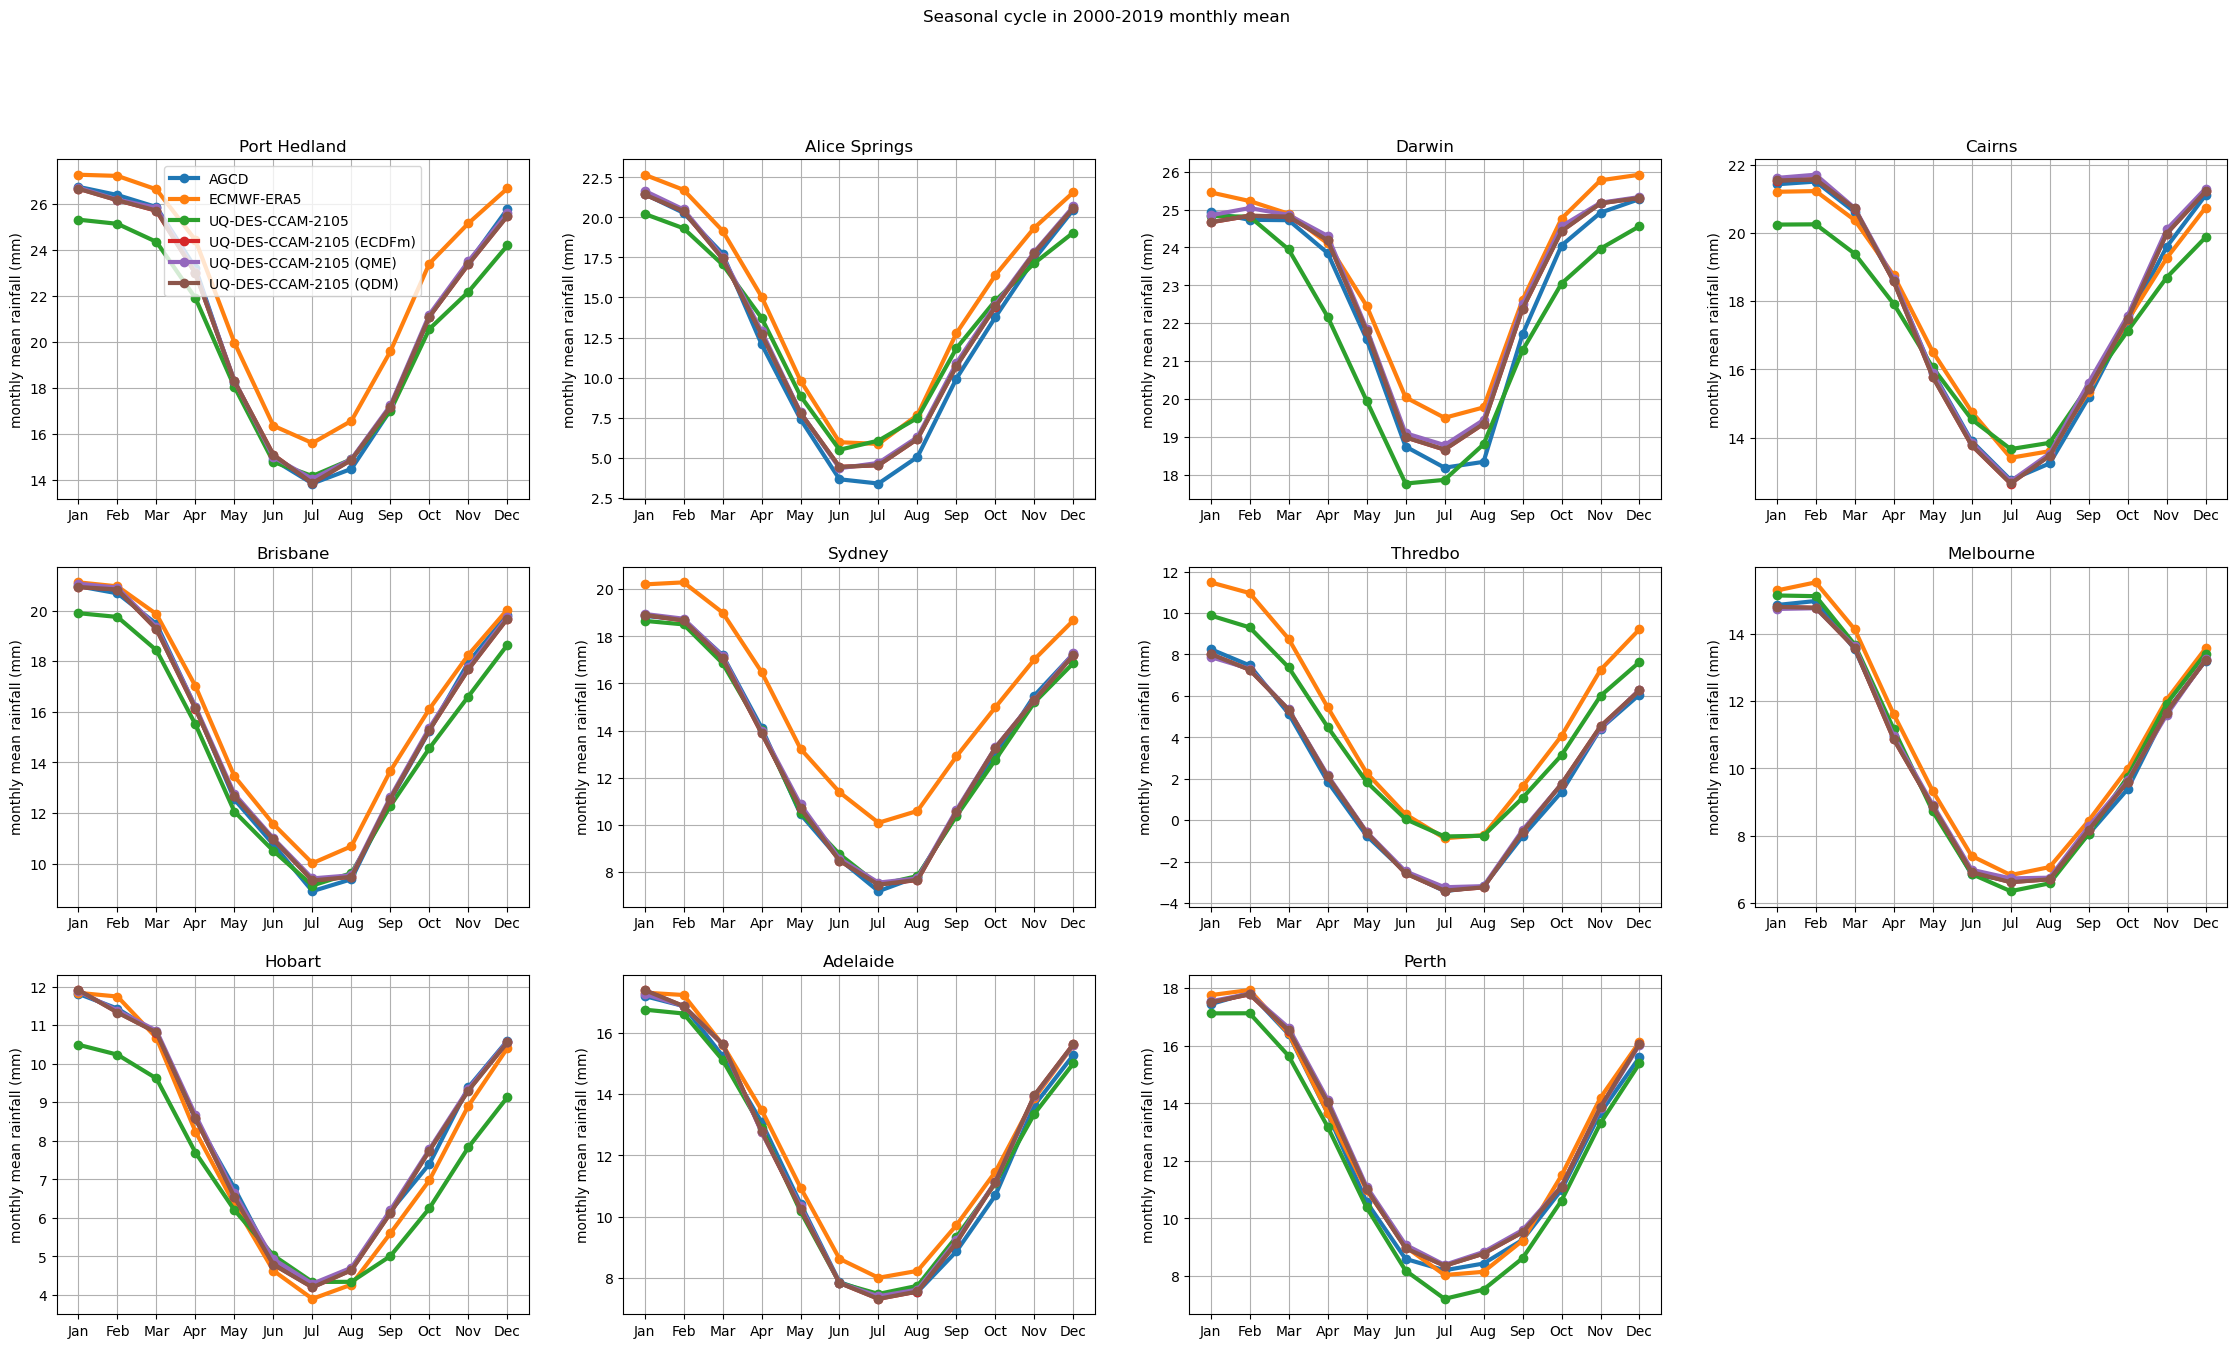

In [31]:
plot_city_cycles(da_dict, gcm, rcm, task)

### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [32]:
gcm = 'CSIRO-ACCESS-ESM1-5'
rcm = 'BOM-BARPA-R'
task = 'xvalidation'
da_dict = get_data(variable, gcm, rcm, task)

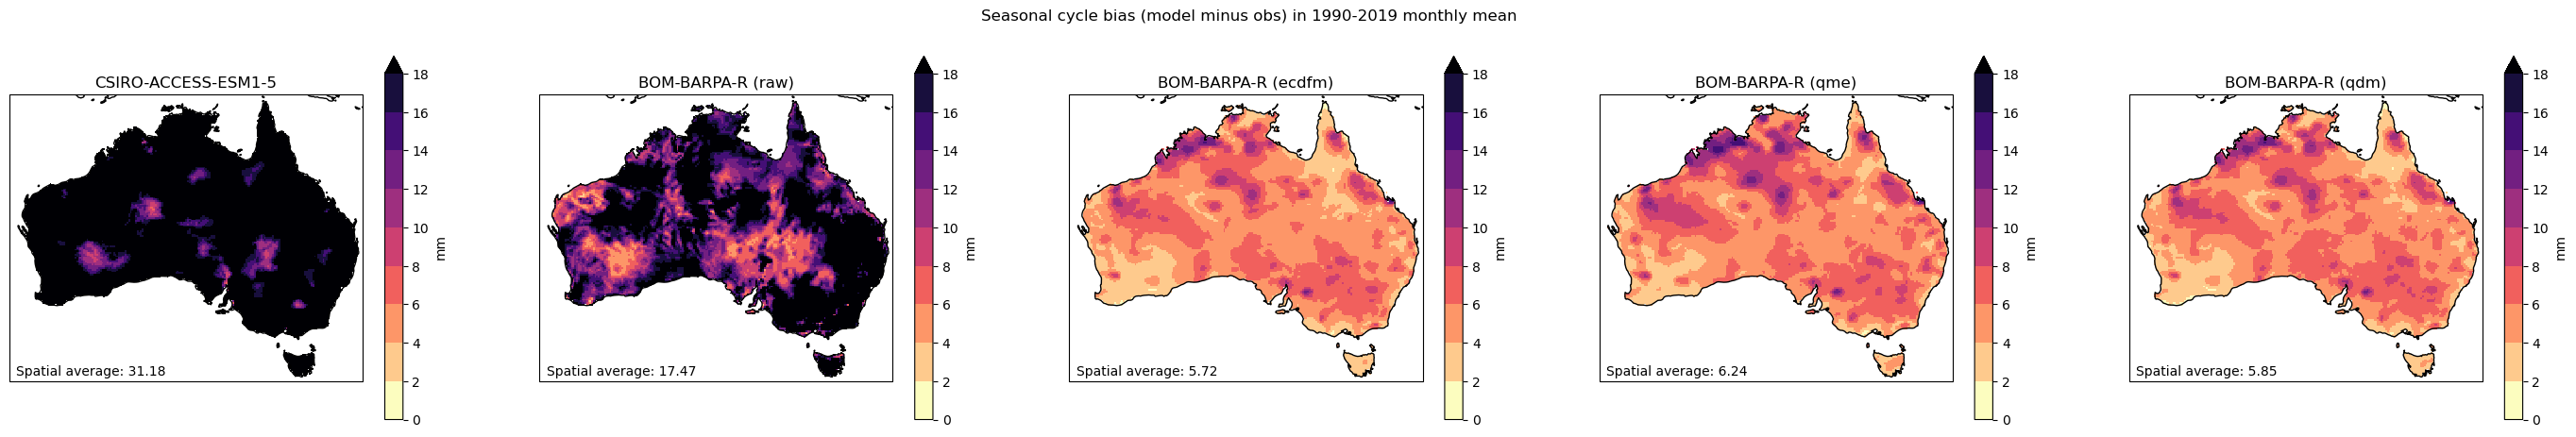

In [33]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [34]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, frac_levels, fraction=True)

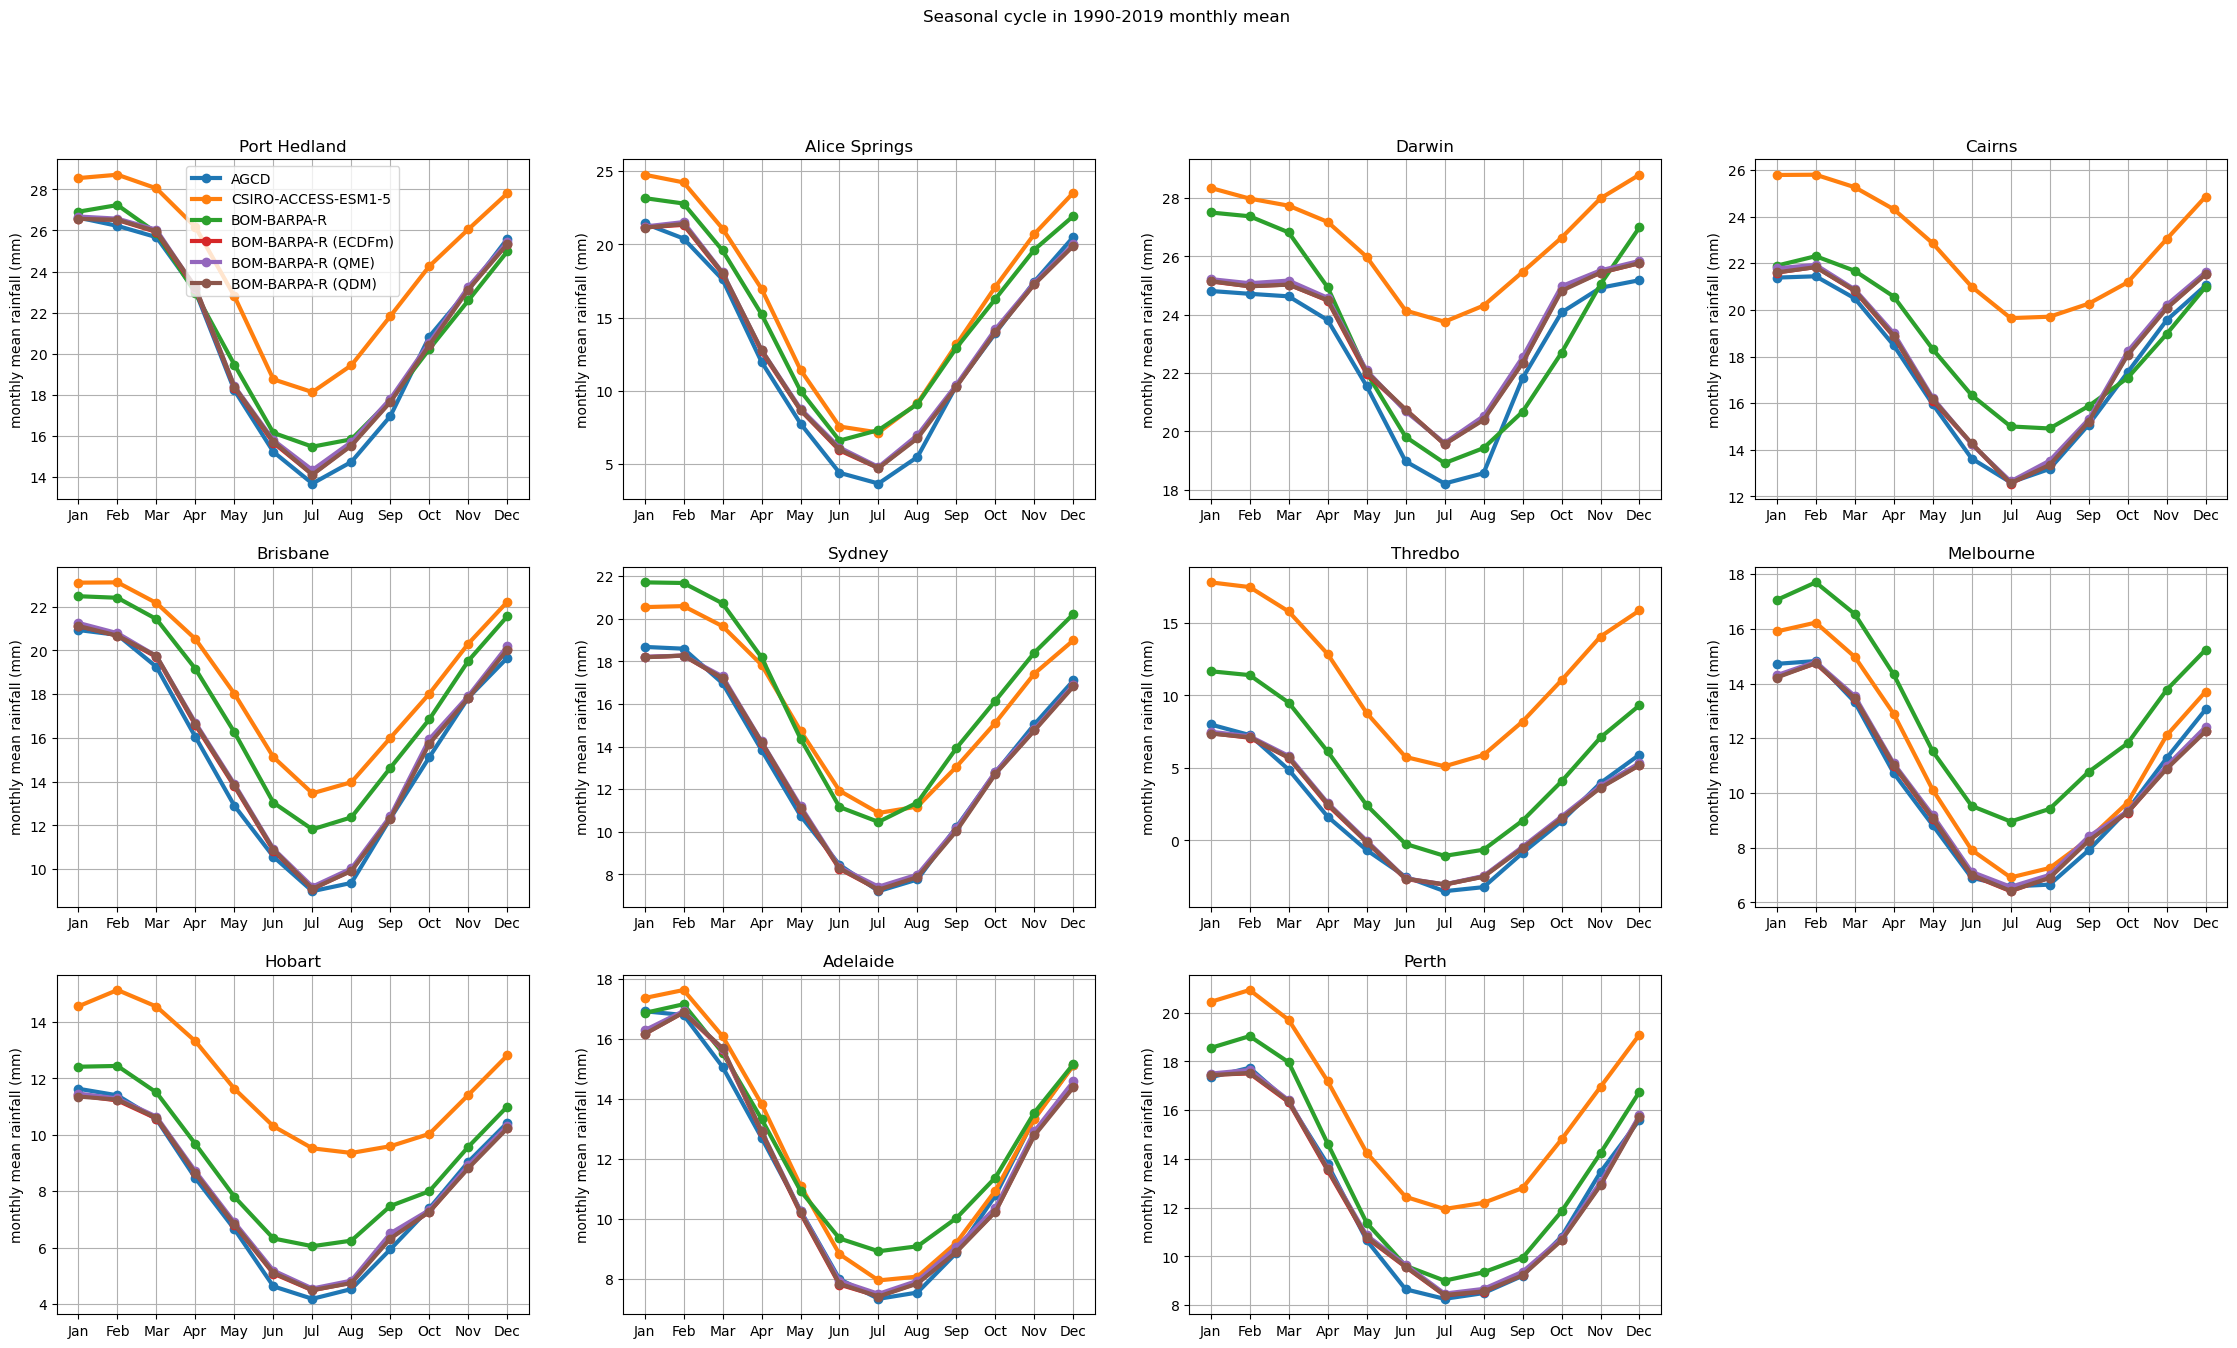

In [35]:
plot_city_cycles(da_dict, gcm, rcm, task)

In [36]:
gcm = 'CSIRO-ACCESS-ESM1-5'
rcm = 'CSIRO-CCAM-2203'
task = 'xvalidation'
da_dict = get_data(variable, gcm, rcm, task)

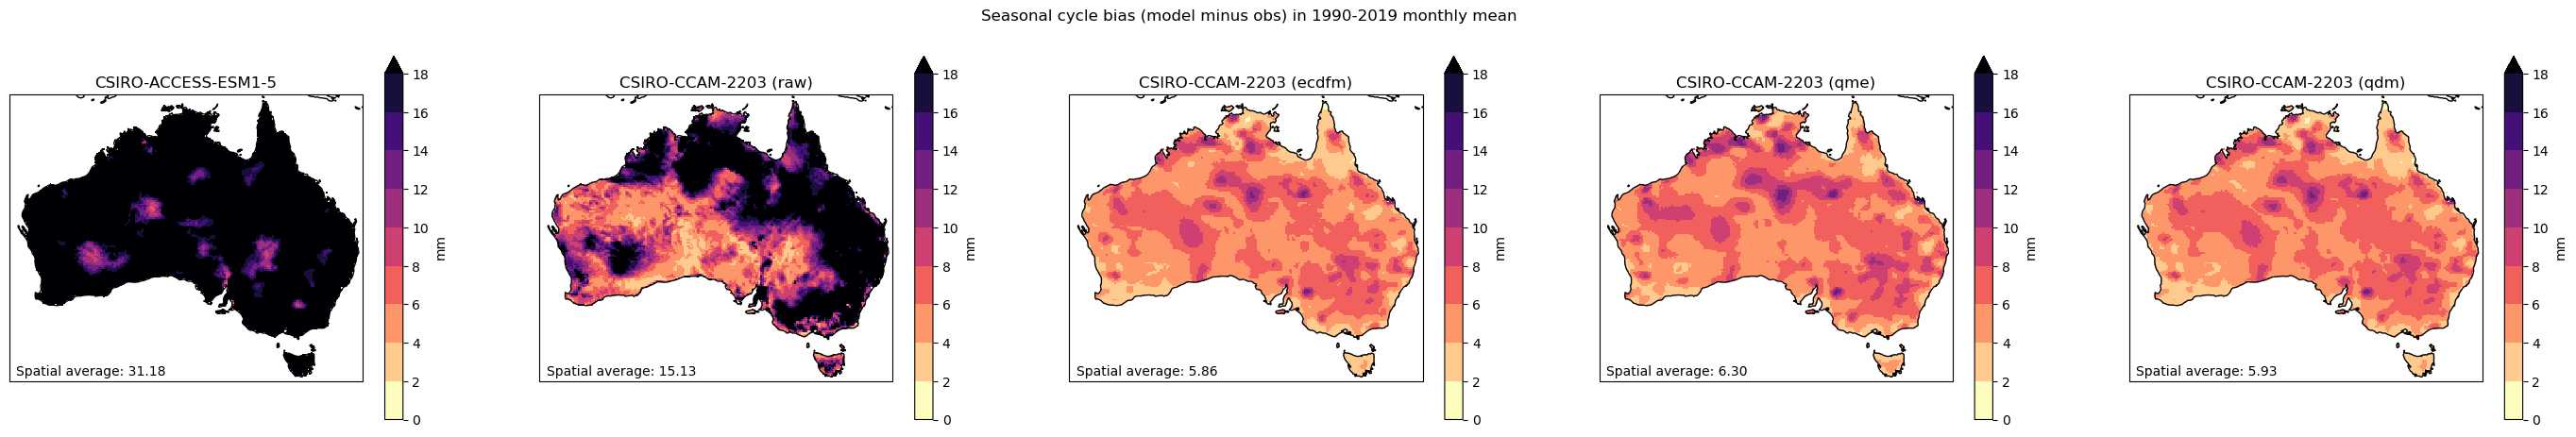

In [37]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [38]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, frac_levels, fraction=True)

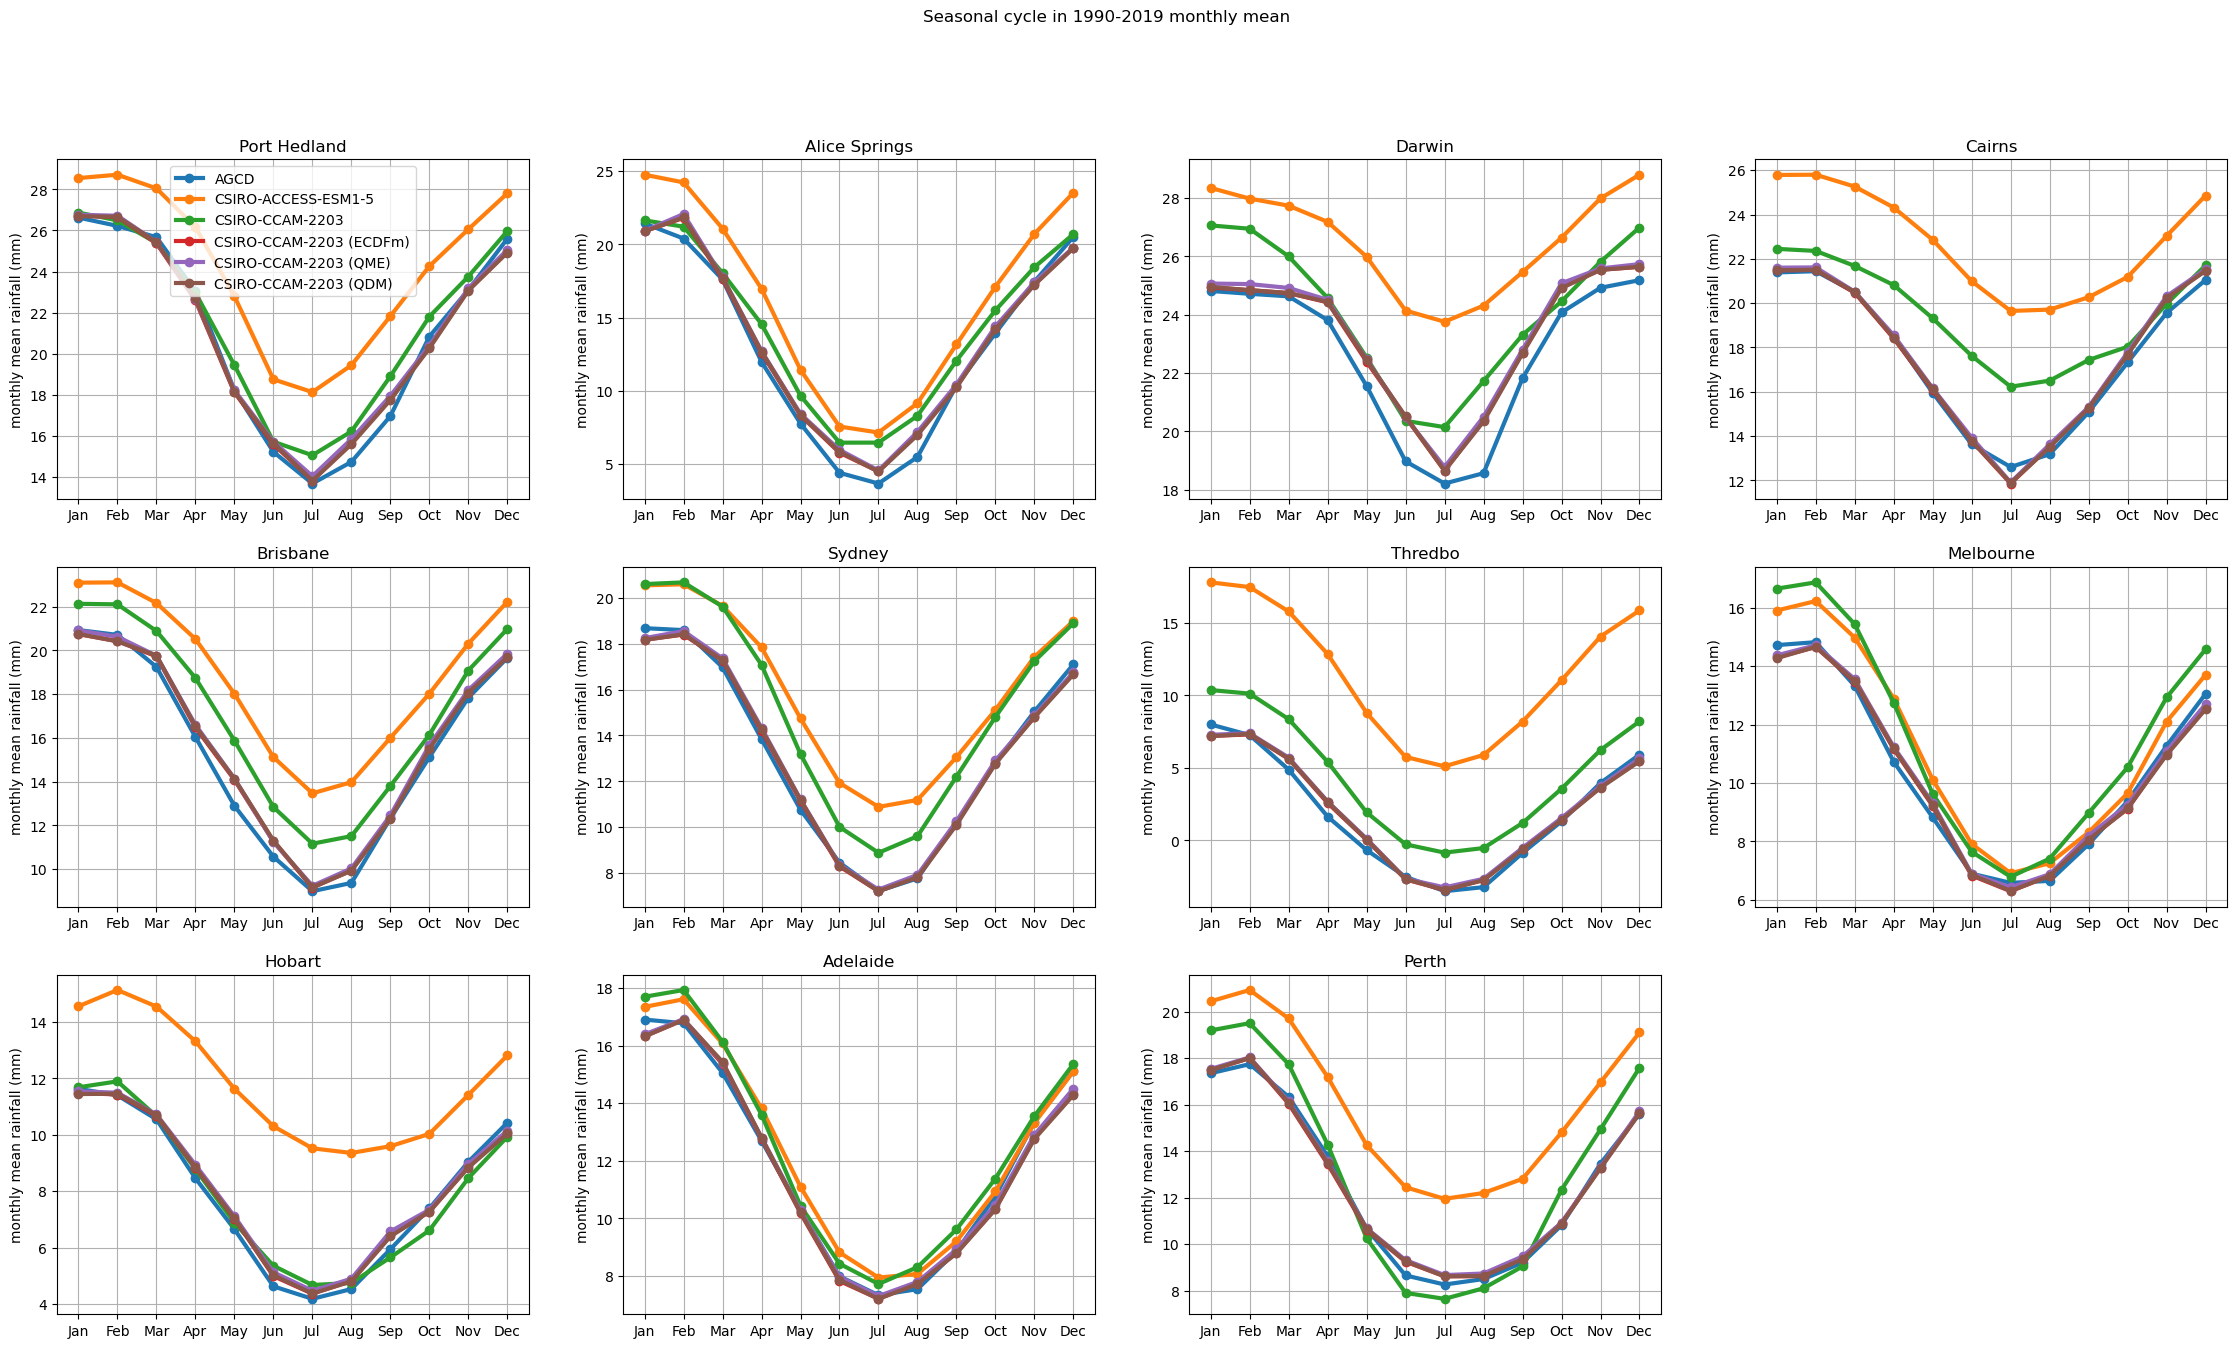

In [39]:
plot_city_cycles(da_dict, gcm, rcm, task)

In [40]:
gcm = 'CSIRO-ACCESS-ESM1-5'
rcm = 'UQ-DES-CCAM-2105'
task = 'xvalidation'
da_dict = get_data(variable, gcm, rcm, task)

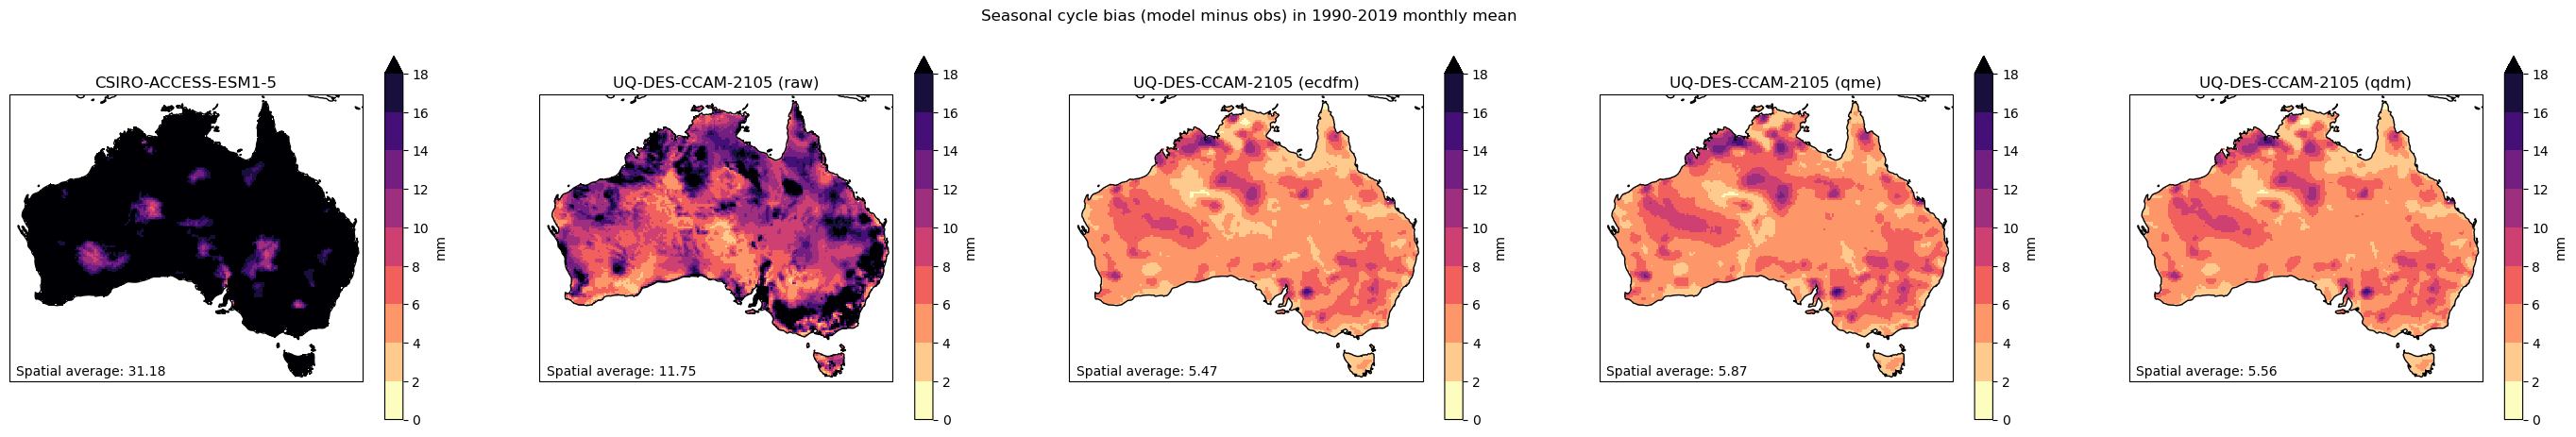

In [41]:
plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, bias_levels, fraction=False)

In [42]:
if variable == 'pr':
    plot_cycle_bias_comparison(da_dict, variable, gcm, rcm, task, cmap, frac_levels, fraction=True)

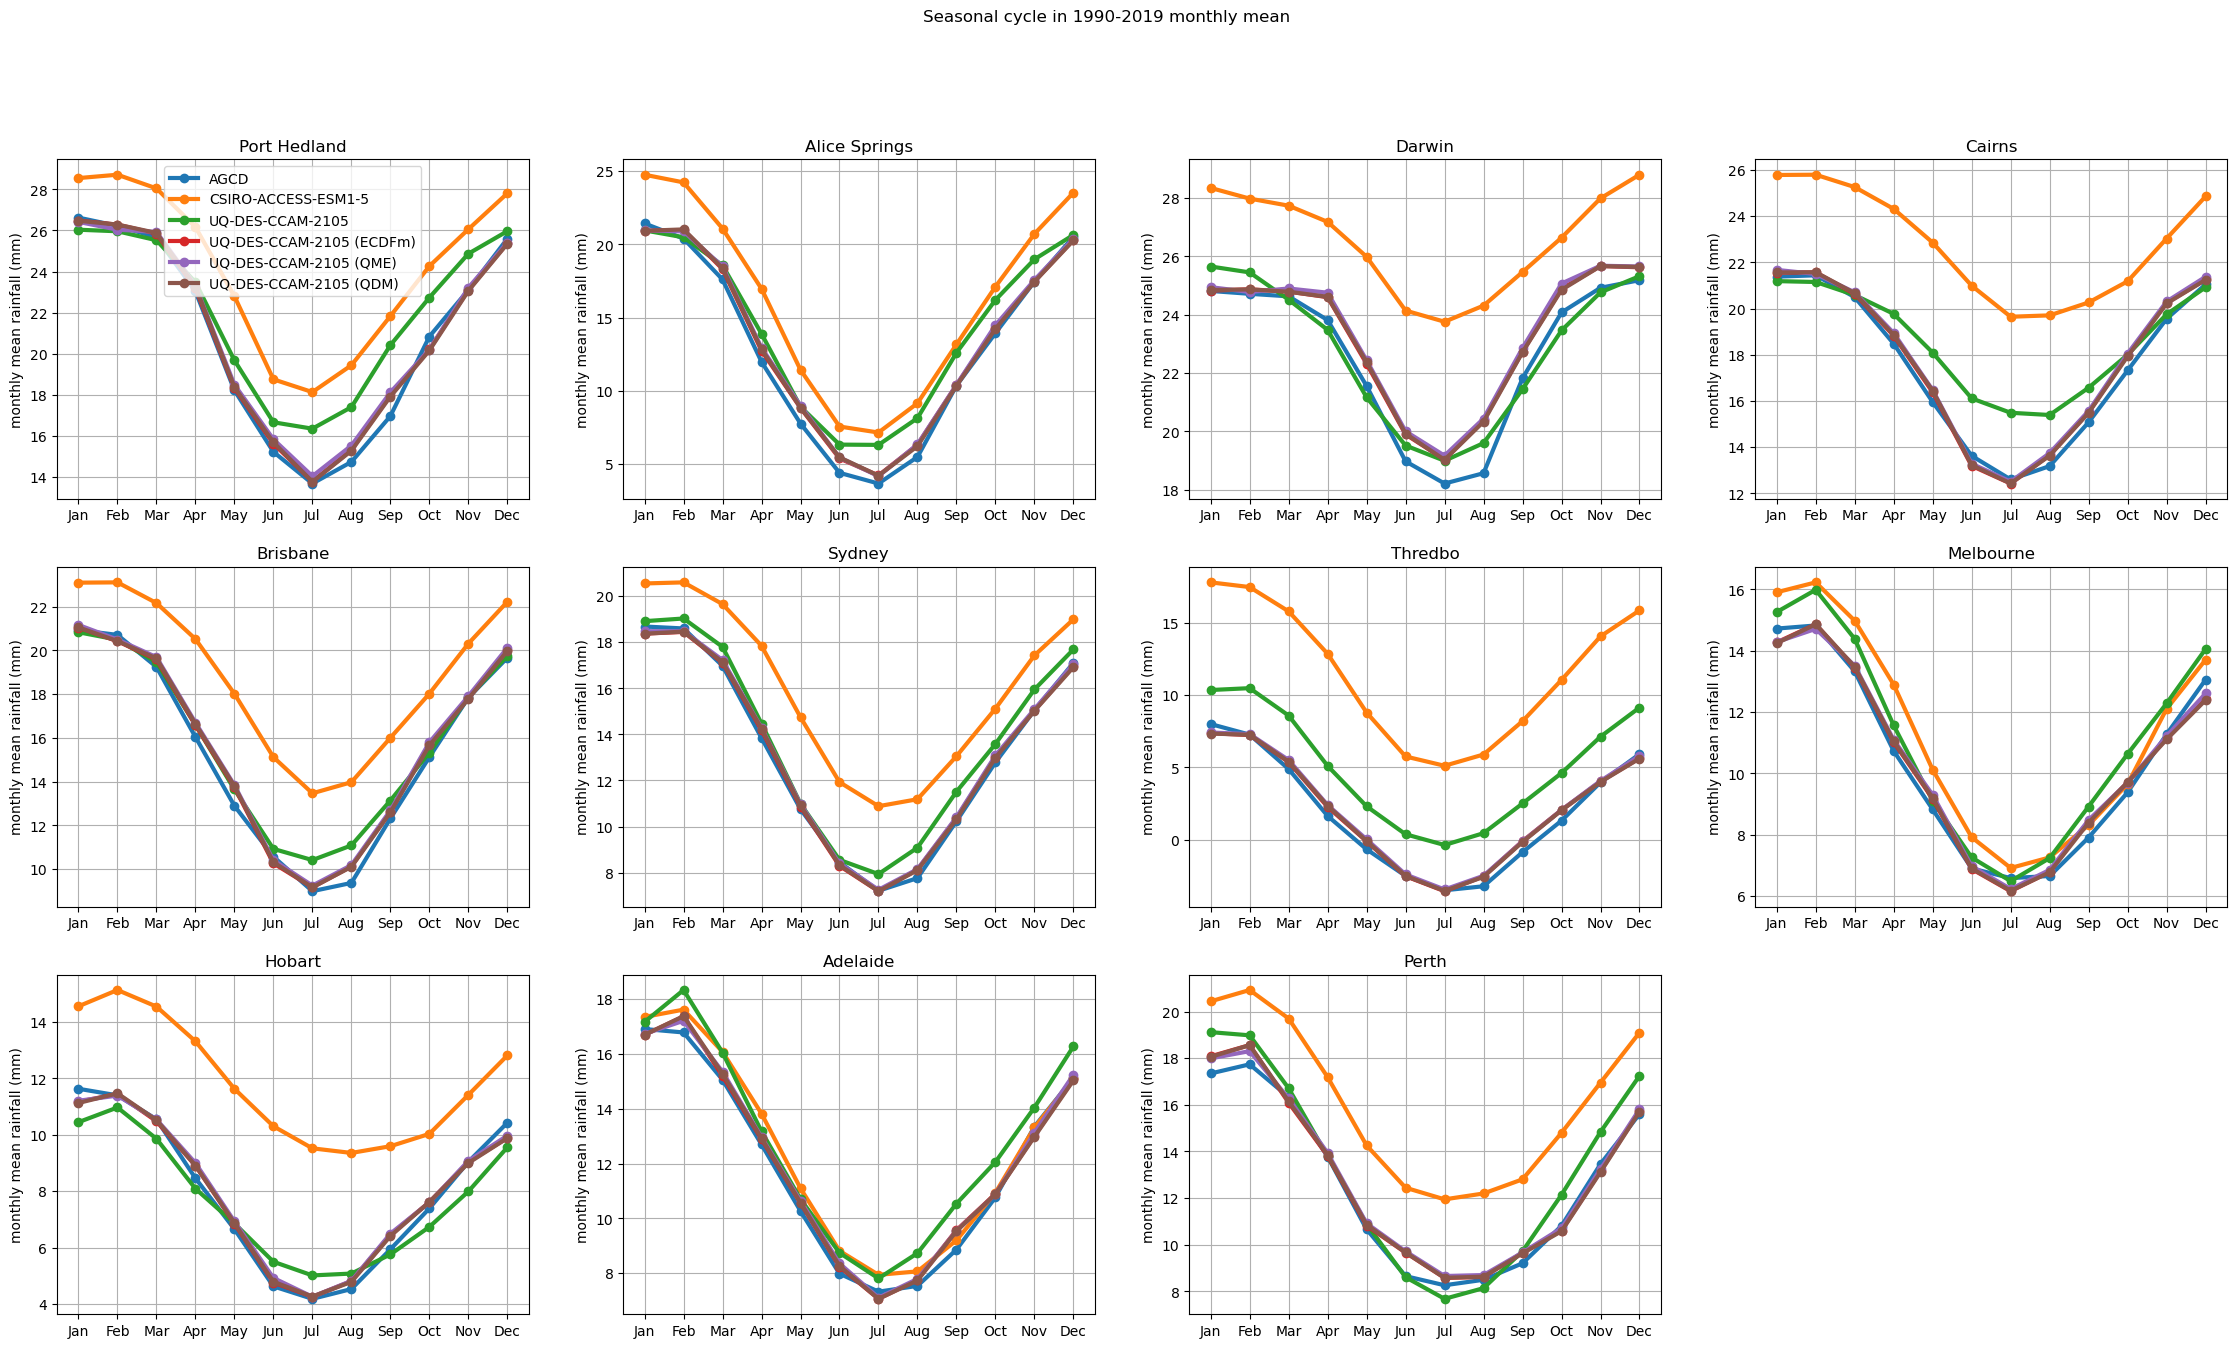

In [43]:
plot_city_cycles(da_dict, gcm, rcm, task)